In [51]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
importlib.reload(mf)
from collections import defaultdict

## FUNCTIONS ##

In [27]:
def read_B_field(file_name):
    match = re.search(r'fld_([0-9.]+)', file_name)
    if match: 
        
        b_field = float(match.group(1).strip("."))
        return b_field
    else: 
        print("Error: field value not found in filename.")

## SINGLE SPECTRUM ##

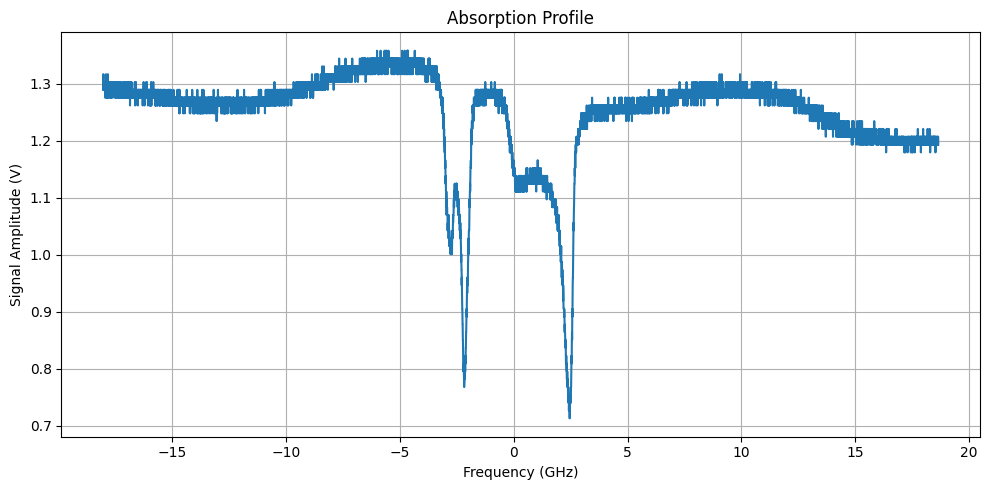

In [20]:
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 14-10-25_freq_195.11758_rng_36.6821_gain_30_fld_0.08736.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

# Plot absorption profile
plt.figure(figsize=(10, 5))
plt.plot(freq_axis_GHz, voltage)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Signal Amplitude (V)")
plt.title("Absorption Profile")
plt.grid(True)
plt.tight_layout()
plt.show()




## 2D SPECTRA W MAGNETIC FIELD ## 

In [11]:
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/"
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]


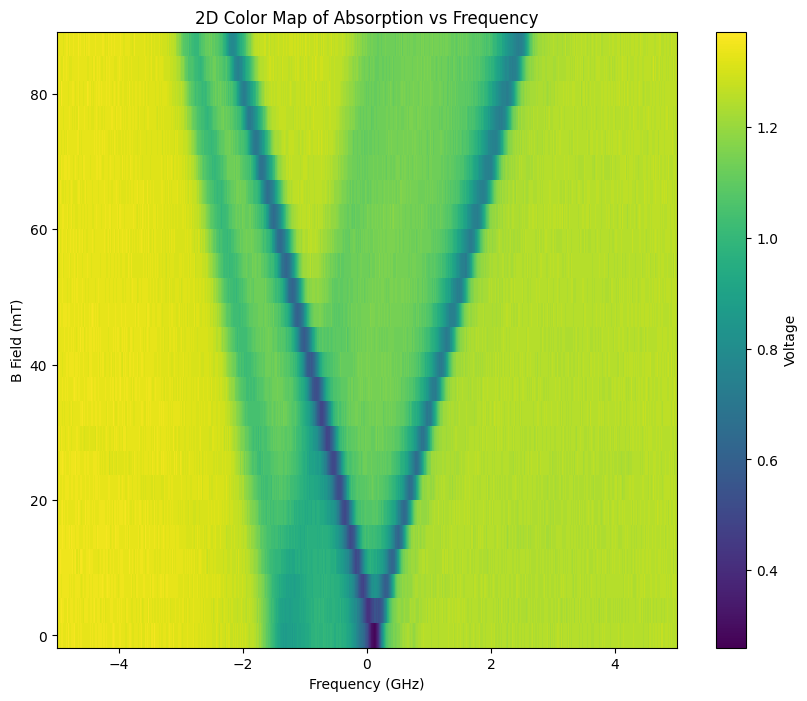

In [17]:
# plot 
plt.figure(figsize=(10,8))
plt.pcolormesh(freq_axis_GHz, fields*1000, voltages, shading='auto', cmap='viridis')
#plt.ylim([80,90])
plt.xlim([-5, 5])
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")
plt.show()


## Linewidths ## 

2.618313746145174
-2.8631781324191645

######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 5.481492
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



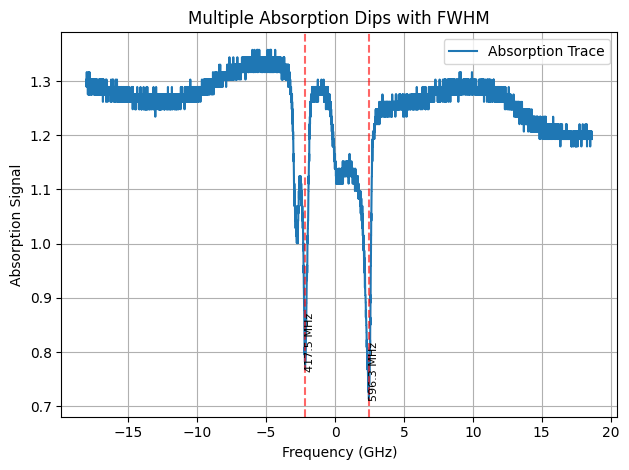

In [3]:
## SINGLE SPECTRUM ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 14-10-25_freq_195.11758_rng_36.6821_gain_30_fld_0.08736.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.180374 GHz
  FWHM:   324.00 MHz
  Depth:  0.4362
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.180374 GHz
  FWHM:   324.00 MHz
  Depth:  0.4362
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 2.348880 GHz
  FWHM:   541.64 MHz
  Depth:  0.5016
#########################################



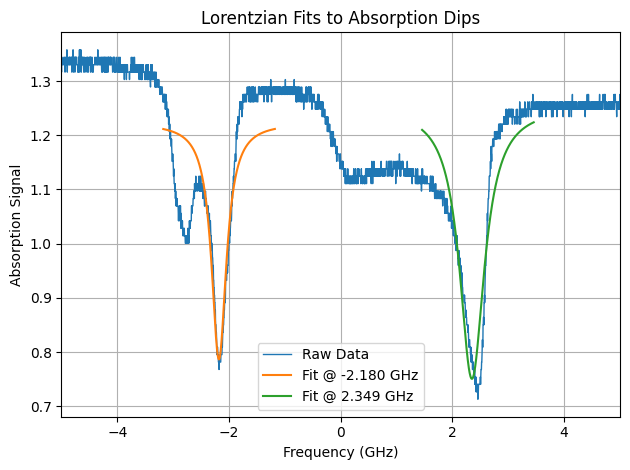

In [26]:
## Lorentzian Fits ##
fits = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=2, min_prominence=0.124, to_print=True)

plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

for f in fits:
    if len(fits)> 5: 
        raise ValueError("WARNING TOO MANY FITS")
    plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz")

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
plt.xlim([-5,5])
plt.title("Lorentzian Fits to Absorption Dips")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Collect Linewidths for All data ## 

In [28]:
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/"
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]

In [31]:
linewidths = [] 
for volt in voltages: 
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=volt, min_prominence=0.2, to_print=True)
    for f in features: 
        linewidths.append(float(f["FWHM"]))
print(linewidths)



######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.012117
FWHM (GHz): 0.591647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.411390
Absorption Depth: 0.946197
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.080040
FWHM (GHz): 0.804530
Baseline (max signal): 1.371300
Dip Value (min signal): 0.479955
Absorption Depth: 0.891345
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.068981
FWHM (GHz


######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.012117
FWHM (GHz): 0.591647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.411390
Absorption Depth: 0.946197
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.080040
FWHM (GHz): 0.804530
Baseline (max signal): 1.371300
Dip Value (min signal): 0.479955
Absorption Depth: 0.891345
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.068981
FWHM (GHz

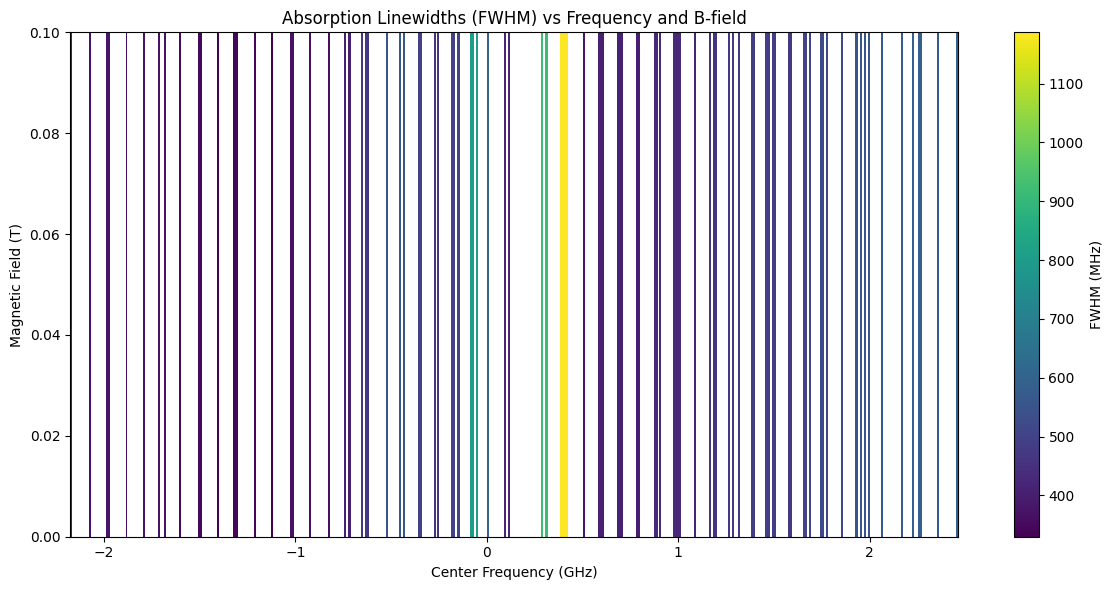

In [38]:
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/"
data_files = sorted(glob.glob(data_path + "*.csv"))

# Parameters
min_prominence = 0.2
freq_bin_resolution = 0.01  # GHz
field_bin_resolution = 0.1  # T

# Storage
f_dip_list = []
B_list = []
FWHM_list = []

# === Read all data ===
for file in data_files:
    data = pd.read_csv(file, header=None)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=min_prominence)

    for f in features:
        f_dip_list.append(f["f_dip"])
        B_list.append(B_field)
        FWHM_list.append(f["FWHM"] * 1e3)  # MHz

# Convert to arrays
f_dip_array = np.array(f_dip_list)
B_array = np.array(B_list)
FWHM_array = np.array(FWHM_list)

# Define bin edges
freq_bins = np.arange(np.min(f_dip_array), np.max(f_dip_array) + freq_bin_resolution, freq_bin_resolution)
field_bins = np.arange(np.min(B_array), np.max(B_array) + field_bin_resolution, field_bin_resolution)

# Create grid for mean FWHM
fwhm_grid = np.full((len(field_bins) - 1, len(freq_bins) - 1), np.nan)
counts = np.zeros_like(fwhm_grid)

# Bin indices for each point
freq_indices = np.digitize(f_dip_array, freq_bins) - 1
field_indices = np.digitize(B_array, field_bins) - 1

# Fill grid
for i in range(len(FWHM_array)):
    fi = field_indices[i]
    fj = freq_indices[i]
    if 0 <= fi < fwhm_grid.shape[0] and 0 <= fj < fwhm_grid.shape[1]:
        if np.isnan(fwhm_grid[fi, fj]):
            fwhm_grid[fi, fj] = FWHM_array[i]
            counts[fi, fj] = 1
        else:
            fwhm_grid[fi, fj] += FWHM_array[i]
            counts[fi, fj] += 1

# Average FWHMs where multiple values exist
fwhm_grid[counts > 0] /= counts[counts > 0]

# Debug: how many bins got filled?
print(f"Filled {np.count_nonzero(~np.isnan(fwhm_grid))} of {fwhm_grid.size} bins.")

# Plot using pcolormesh
X, Y = np.meshgrid(freq_bins, field_bins)

plt.figure(figsize=(12, 6))
c = plt.pcolormesh(X, Y, fwhm_grid, shading='auto', cmap='viridis')
plt.xlabel("Center Frequency (GHz)")
plt.ylabel("Magnetic Field (T)")
plt.title("Absorption Linewidths (FWHM) vs Frequency and B-field")
plt.colorbar(c, label="FWHM (MHz)")
plt.tight_layout()
plt.show()


## Linewidth Change Estimate Start Finish ## 

0.2480385088103575
-0.17956946557663722

######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.427608
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################



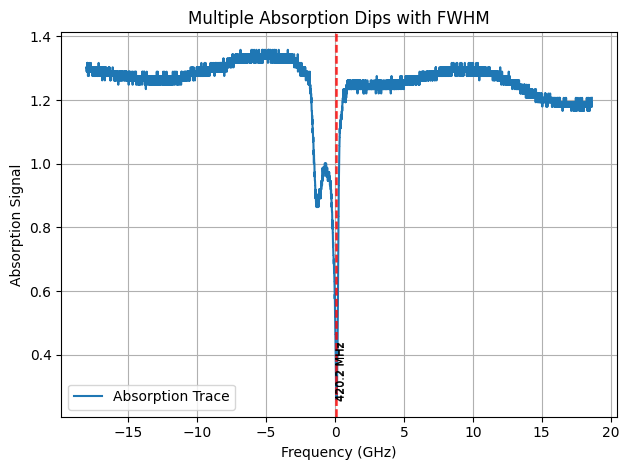

2.618313746145174
-2.8631781324191645

######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 5.481492
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



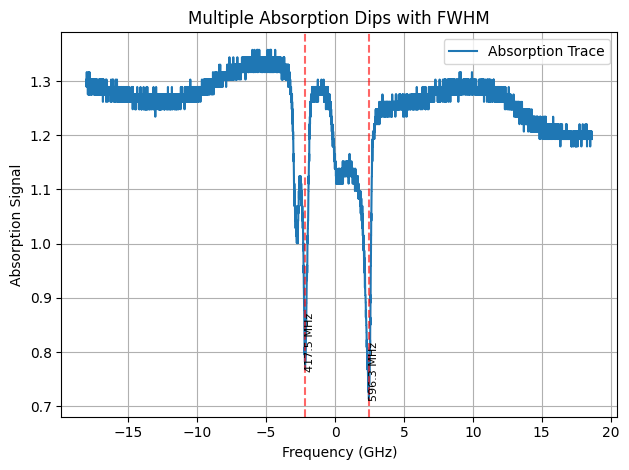

In [39]:
## SINGLE SPECTRUM 1  ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 13-41-42_freq_195.11758_rng_36.6821_gain_30_fld_0.0.csv"

"data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 13-46-29_freq_195.11758_rng_36.6821_gain_30_fld_0.01456.csv"
# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## SINGLE SPECTRUM 2 ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 14-10-25_freq_195.11758_rng_36.6821_gain_30_fld_0.08736.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



0.6166660729370783
-0.5813735104747628

######## Absorption Dip Features ########
Min Frequency (GHz): -0.268040
FWHM (GHz): 1.198040
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.268040
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.256981
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.506078
FWHM (GHz): 0.379686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.617085
Absorption Depth: 0.740502
#########################################



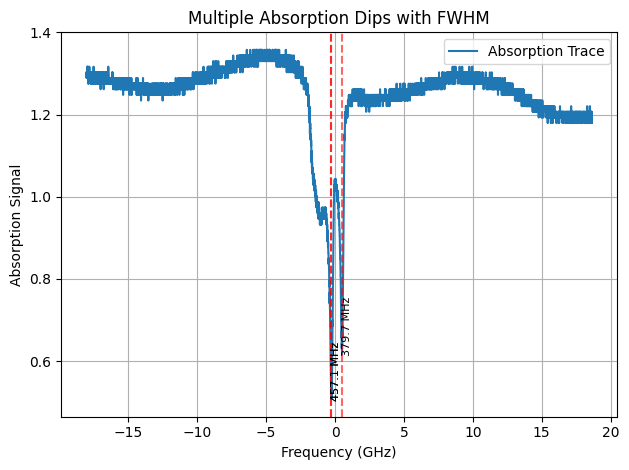

2.618313746145174
-2.8631781324191645

######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 5.481492
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



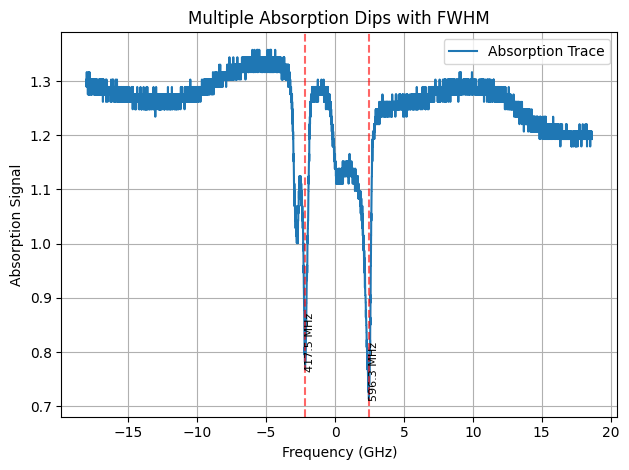

In [40]:
## SINGLE SPECTRUM 1  ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 13-46-29_freq_195.11758_rng_36.6821_gain_30_fld_0.01456.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## SINGLE SPECTRUM 2 ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 14-10-25_freq_195.11758_rng_36.6821_gain_30_fld_0.08736.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



## Linewidth Vs Central Frequency non-Lorentzian ## 


######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################



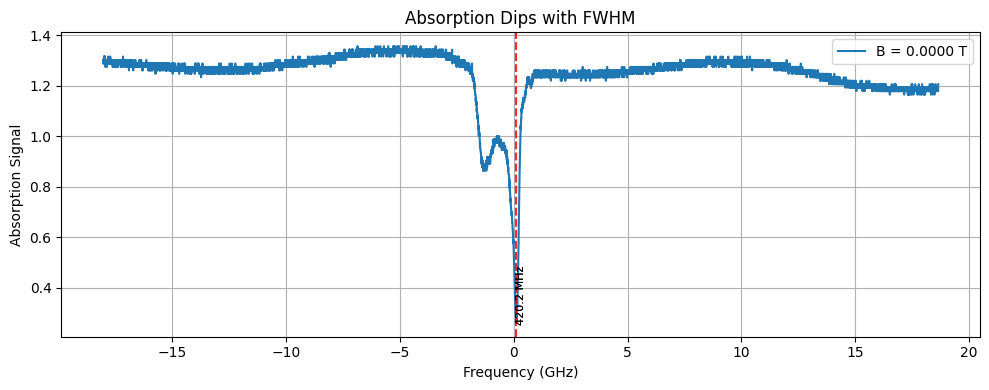


######## Absorption Dip Features ########
Min Frequency (GHz): 0.012117
FWHM (GHz): 0.591647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.411390
Absorption Depth: 0.946197
#########################################



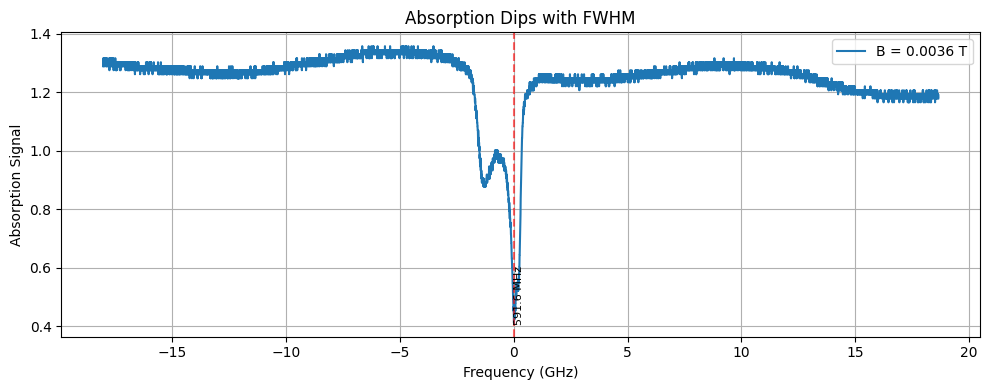


######## Absorption Dip Features ########
Min Frequency (GHz): -0.080040
FWHM (GHz): 0.804530
Baseline (max signal): 1.371300
Dip Value (min signal): 0.479955
Absorption Depth: 0.891345
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.068981
FWHM (GHz): 0.804530
Baseline (max signal): 1.371300
Dip Value (min signal): 0.479955
Absorption Depth: 0.891345
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.054236
FWHM (GHz): 0.804530
Baseline (max signal): 1.371300
Dip Value (min signal): 0.479955
Absorption Depth: 0.891345
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.292274
FWHM (GHz): 0.917883
Baseline (max signal): 1.371300
Dip Value (min signal): 0.575946
Absorption Depth: 0.795354
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.307019
FWHM (GH

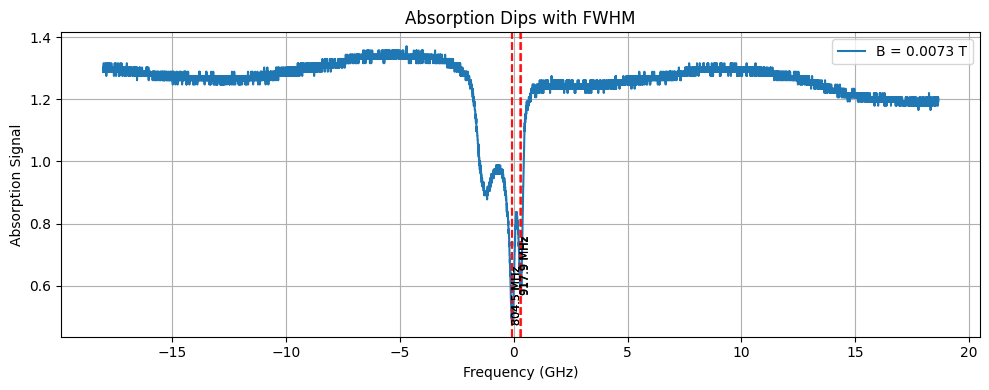


######## Absorption Dip Features ########
Min Frequency (GHz): -0.183256
FWHM (GHz): 0.497647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.168511
FWHM (GHz): 0.497647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.157452
FWHM (GHz): 0.497647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.146393
FWHM (GHz): 0.497647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.391803
FWHM (G

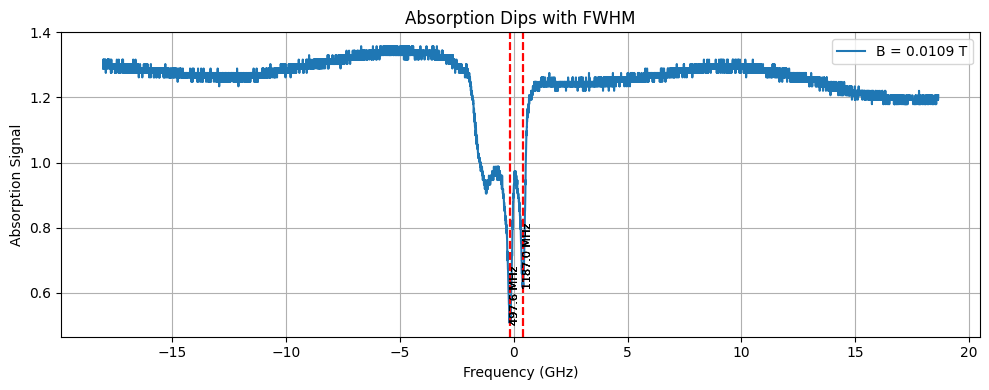


######## Absorption Dip Features ########
Min Frequency (GHz): -0.268040
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.256981
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.506078
FWHM (GHz): 0.379686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.617085
Absorption Depth: 0.740502
#########################################



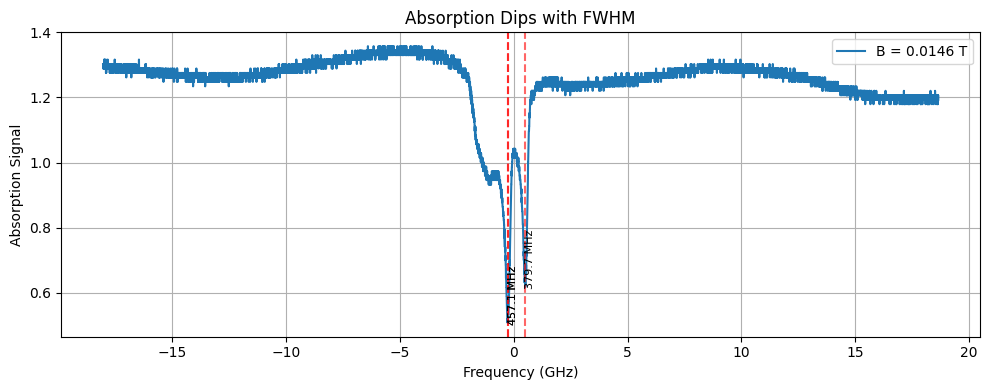


######## Absorption Dip Features ########
Min Frequency (GHz): -0.356511
FWHM (GHz): 0.493961
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.345452
FWHM (GHz): 0.493961
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.587176
FWHM (GHz): 0.409177
Baseline (max signal): 1.357587
Dip Value (min signal): 0.644511
Absorption Depth: 0.713076
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.598235
FWHM (GHz): 0.409177
Baseline (max signal): 1.357587
Dip Value (min signal): 0.644511
Absorption Depth: 0.713076
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.605607
FWHM (GHz

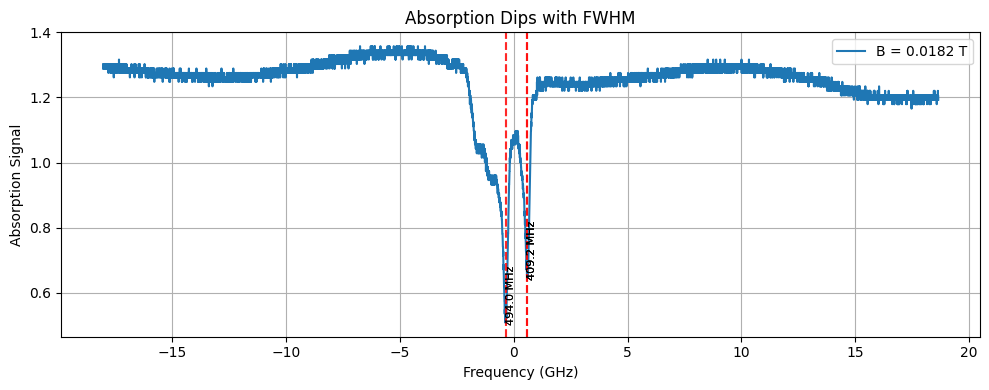


######## Absorption Dip Features ########
Min Frequency (GHz): -0.448668
FWHM (GHz): 0.568608
Baseline (max signal): 1.371300
Dip Value (min signal): 0.507381
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.433922
FWHM (GHz): 0.568608
Baseline (max signal): 1.371300
Dip Value (min signal): 0.507381
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.686705
FWHM (GHz): 0.409177
Baseline (max signal): 1.371300
Dip Value (min signal): 0.658224
Absorption Depth: 0.713076
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.694078
FWHM (GHz): 0.409177
Baseline (max signal): 1.371300
Dip Value (min signal): 0.658224
Absorption Depth: 0.713076
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.708823
FWHM (GHz

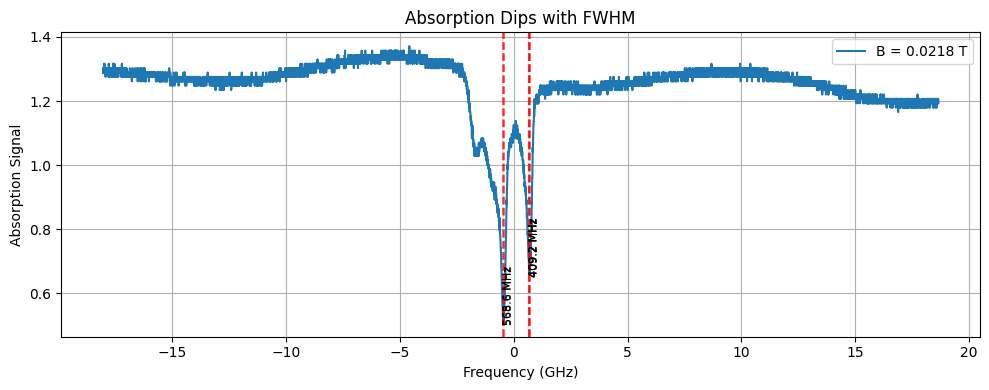


######## Absorption Dip Features ########
Min Frequency (GHz): -0.526079
FWHM (GHz): 0.560314
Baseline (max signal): 1.371300
Dip Value (min signal): 0.493668
Absorption Depth: 0.877632
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.782548
FWHM (GHz): 0.401804
Baseline (max signal): 1.371300
Dip Value (min signal): 0.658224
Absorption Depth: 0.713076
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.800980
FWHM (GHz): 0.401804
Baseline (max signal): 1.371300
Dip Value (min signal): 0.658224
Absorption Depth: 0.713076
#########################################



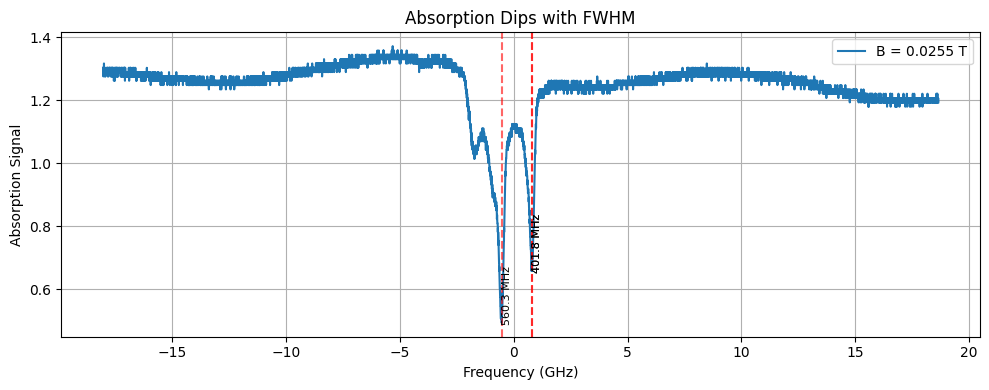


######## Absorption Dip Features ########
Min Frequency (GHz): -0.651413
FWHM (GHz): 0.470000
Baseline (max signal): 1.357587
Dip Value (min signal): 0.493668
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.636668
FWHM (GHz): 0.470000
Baseline (max signal): 1.357587
Dip Value (min signal): 0.493668
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.625609
FWHM (GHz): 0.470000
Baseline (max signal): 1.357587
Dip Value (min signal): 0.493668
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.882078
FWHM (GHz): 0.429451
Baseline (max signal): 1.357587
Dip Value (min signal): 0.685650
Absorption Depth: 0.671937
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.889450
FWHM (GH

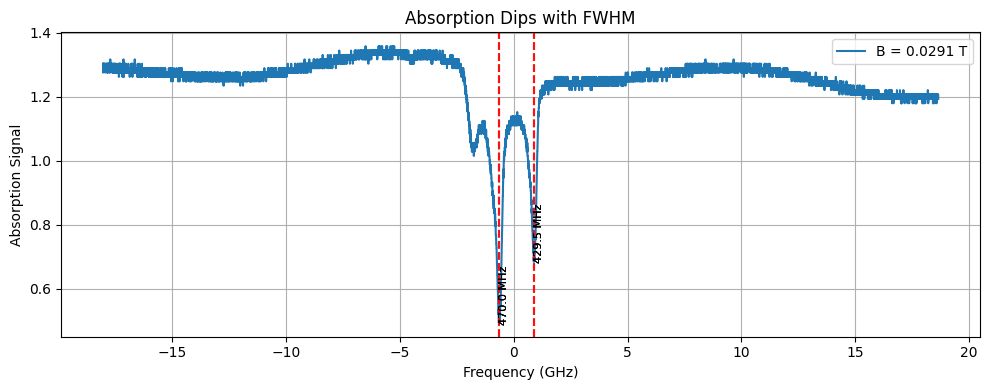


######## Absorption Dip Features ########
Min Frequency (GHz): -0.739883
FWHM (GHz): 0.404569
Baseline (max signal): 1.357587
Dip Value (min signal): 0.493668
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.717766
FWHM (GHz): 0.404569
Baseline (max signal): 1.357587
Dip Value (min signal): 0.493668
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.710393
FWHM (GHz): 0.404569
Baseline (max signal): 1.357587
Dip Value (min signal): 0.493668
Absorption Depth: 0.863919
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.977921
FWHM (GHz): 0.423922
Baseline (max signal): 1.357587
Dip Value (min signal): 0.699363
Absorption Depth: 0.658224
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.985294
FWHM (GH

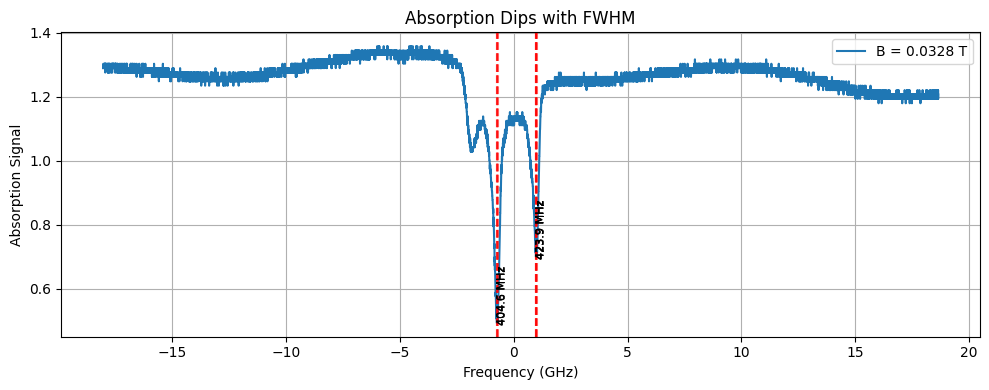


######## Absorption Dip Features ########
Min Frequency (GHz): -0.824668
FWHM (GHz): 0.361255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.092196
FWHM (GHz): 0.416549
Baseline (max signal): 1.357587
Dip Value (min signal): 0.699363
Absorption Depth: 0.658224
#########################################



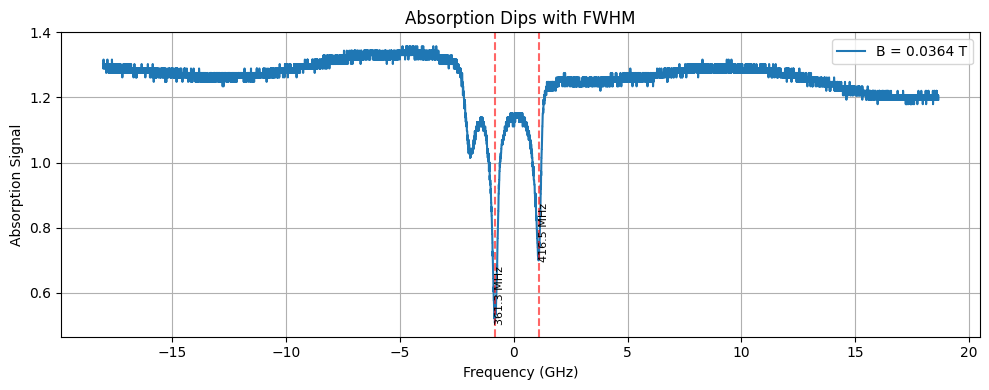


######## Absorption Dip Features ########
Min Frequency (GHz): -0.920511
FWHM (GHz): 0.366784
Baseline (max signal): 1.357587
Dip Value (min signal): 0.548520
Absorption Depth: 0.809067
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.169607
FWHM (GHz): 0.456177
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.184353
FWHM (GHz): 0.456177
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.199098
FWHM (GHz): 0.456177
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



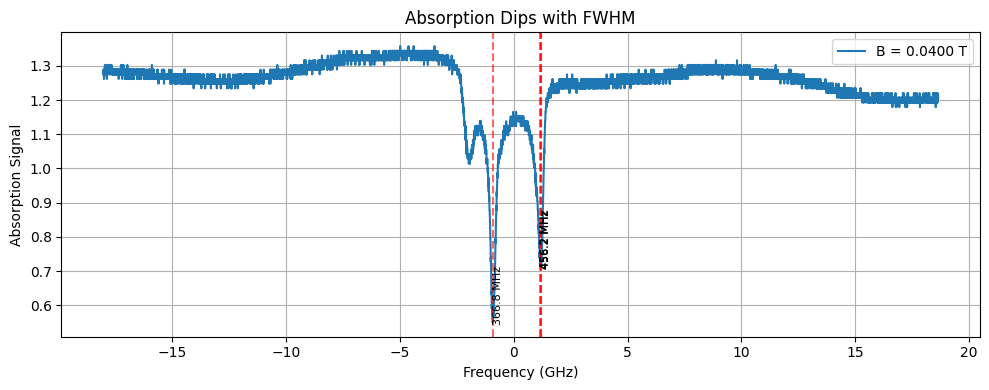


######## Absorption Dip Features ########
Min Frequency (GHz): -1.027413
FWHM (GHz): 0.369549
Baseline (max signal): 1.357587
Dip Value (min signal): 0.575946
Absorption Depth: 0.781641
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.008981
FWHM (GHz): 0.369549
Baseline (max signal): 1.357587
Dip Value (min signal): 0.575946
Absorption Depth: 0.781641
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.265451
FWHM (GHz): 0.473686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.283882
FWHM (GHz): 0.473686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.313372
FWHM (GHz

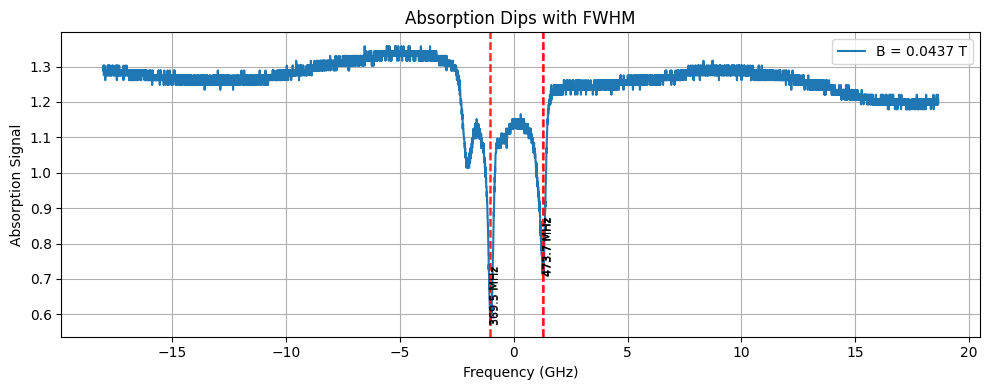


######## Absorption Dip Features ########
Min Frequency (GHz): -1.123256
FWHM (GHz): 0.335451
Baseline (max signal): 1.357587
Dip Value (min signal): 0.589659
Absorption Depth: 0.767928
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.383411
FWHM (GHz): 0.481059
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.394470
FWHM (GHz): 0.481059
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################



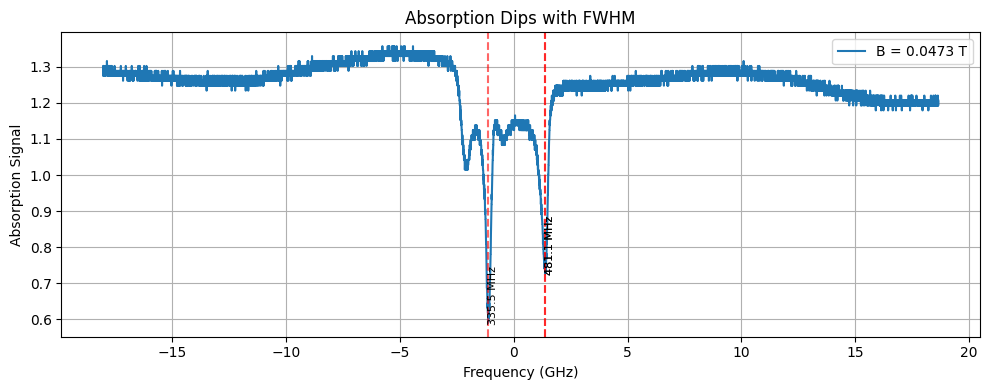


######## Absorption Dip Features ########
Min Frequency (GHz): -1.208040
FWHM (GHz): 0.340980
Baseline (max signal): 1.357587
Dip Value (min signal): 0.603372
Absorption Depth: 0.754215
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.460823
FWHM (GHz): 0.486588
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.471882
FWHM (GHz): 0.486588
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.479255
FWHM (GHz): 0.486588
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.494000
FWHM (GHz)

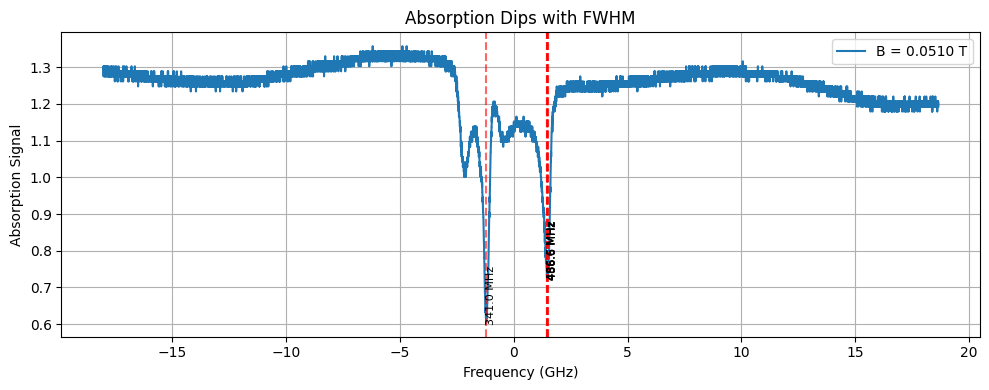


######## Absorption Dip Features ########
Min Frequency (GHz): -1.326001
FWHM (GHz): 0.341902
Baseline (max signal): 1.343874
Dip Value (min signal): 0.617085
Absorption Depth: 0.726789
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.314942
FWHM (GHz): 0.341902
Baseline (max signal): 1.343874
Dip Value (min signal): 0.617085
Absorption Depth: 0.726789
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.300197
FWHM (GHz): 0.341902
Baseline (max signal): 1.343874
Dip Value (min signal): 0.617085
Absorption Depth: 0.726789
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.578784
FWHM (GHz): 0.464471
Baseline (max signal): 1.343874
Dip Value (min signal): 0.713076
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.589843
FWHM (GH

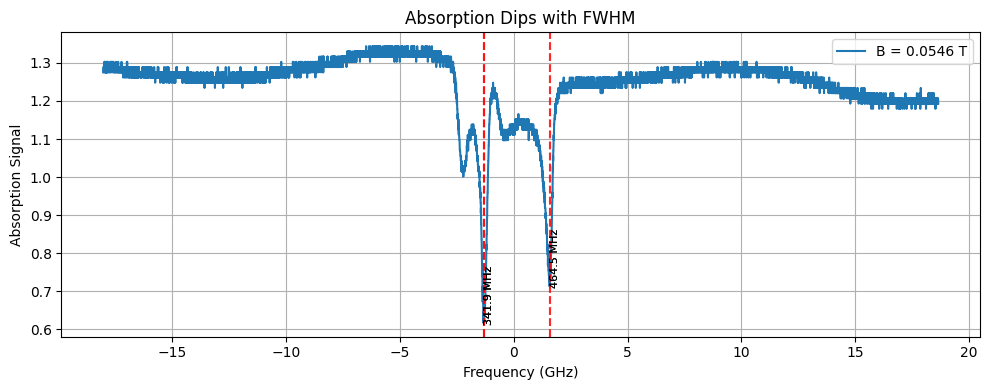


######## Absorption Dip Features ########
Min Frequency (GHz): -1.403413
FWHM (GHz): 0.329922
Baseline (max signal): 1.357587
Dip Value (min signal): 0.617085
Absorption Depth: 0.740502
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.652510
FWHM (GHz): 0.501333
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.670941
FWHM (GHz): 0.501333
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.689372
FWHM (GHz): 0.501333
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################



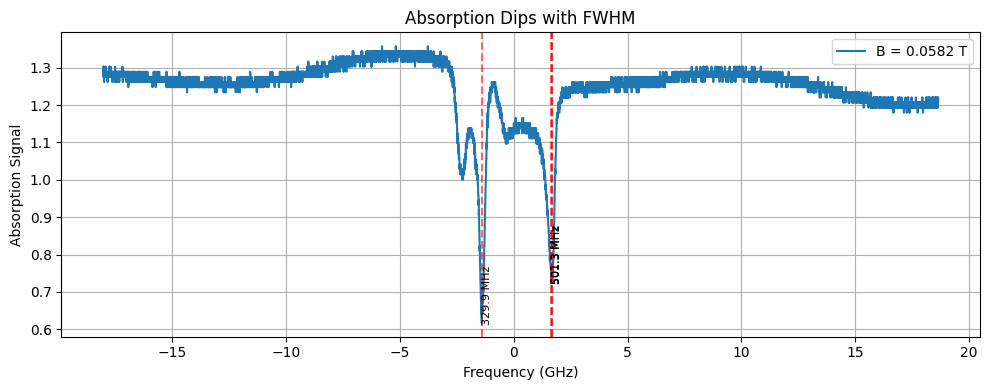


######## Absorption Dip Features ########
Min Frequency (GHz): -1.506629
FWHM (GHz): 0.348353
Baseline (max signal): 1.357587
Dip Value (min signal): 0.644511
Absorption Depth: 0.713076
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.495570
FWHM (GHz): 0.348353
Baseline (max signal): 1.357587
Dip Value (min signal): 0.644511
Absorption Depth: 0.713076
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.748353
FWHM (GHz): 0.523451
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.755725
FWHM (GHz): 0.523451
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.781529
FWHM (GHz

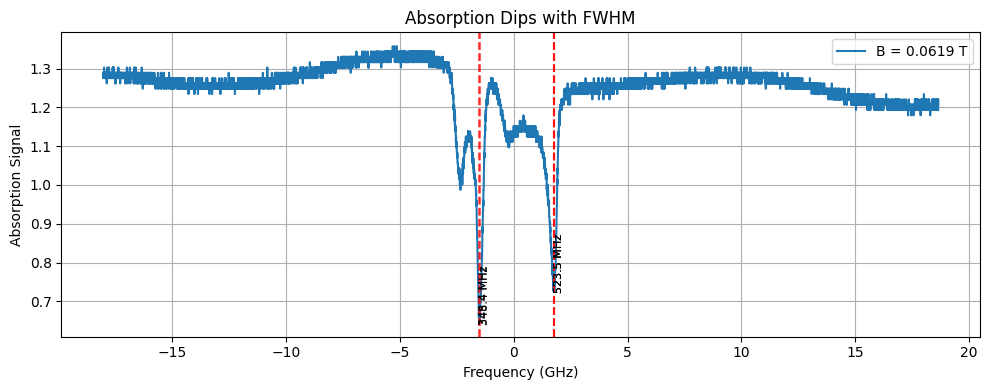


######## Absorption Dip Features ########
Min Frequency (GHz): -1.602472
FWHM (GHz): 0.353882
Baseline (max signal): 1.343874
Dip Value (min signal): 0.658224
Absorption Depth: 0.685650
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.855255
FWHM (GHz): 0.514235
Baseline (max signal): 1.343874
Dip Value (min signal): 0.726789
Absorption Depth: 0.617085
#########################################



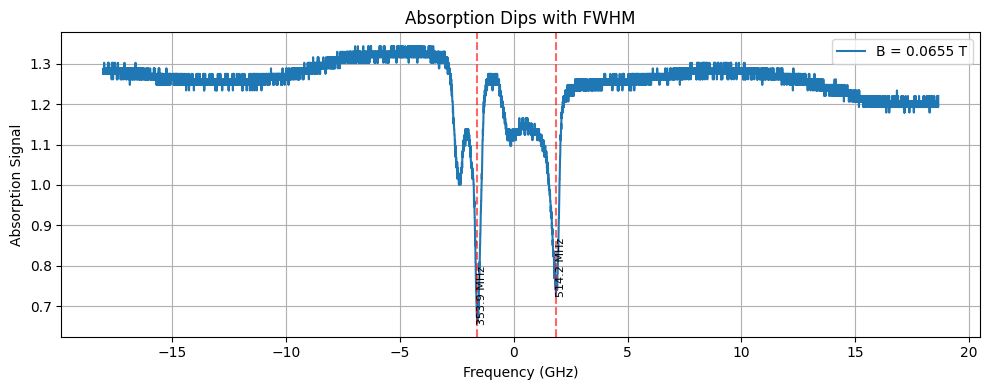


######## Absorption Dip Features ########
Min Frequency (GHz): -1.713060
FWHM (GHz): 0.370471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.685650
Absorption Depth: 0.671937
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.687256
FWHM (GHz): 0.370471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.685650
Absorption Depth: 0.671937
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.925294
FWHM (GHz): 0.559392
Baseline (max signal): 1.357587
Dip Value (min signal): 0.740502
Absorption Depth: 0.617085
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.932666
FWHM (GHz): 0.559392
Baseline (max signal): 1.357587
Dip Value (min signal): 0.740502
Absorption Depth: 0.617085
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 1.958470
FWHM (GHz

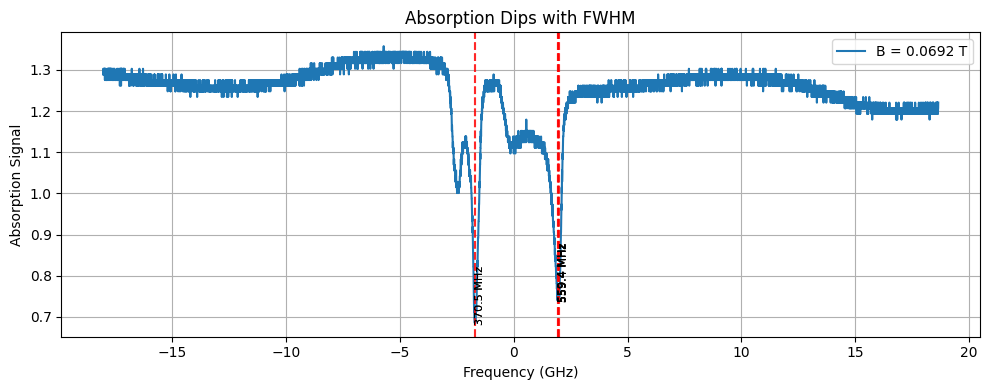


######## Absorption Dip Features ########
Min Frequency (GHz): -1.790472
FWHM (GHz): 0.374157
Baseline (max signal): 1.357587
Dip Value (min signal): 0.685650
Absorption Depth: 0.671937
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.065372
FWHM (GHz): 0.575059
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################



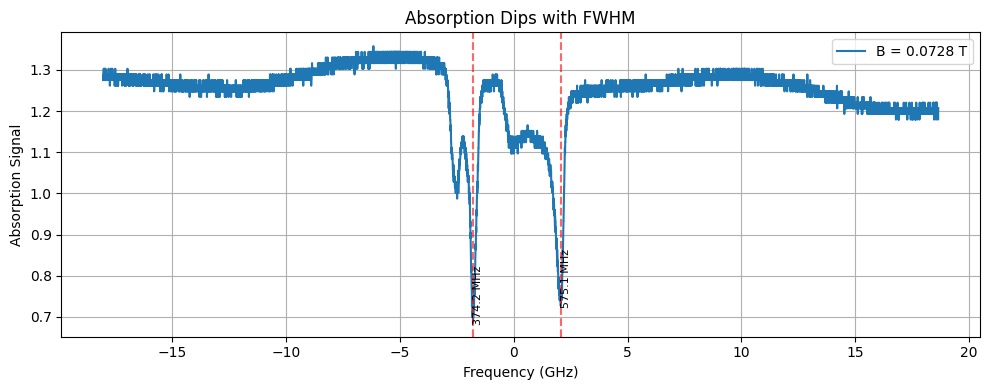


######## Absorption Dip Features ########
Min Frequency (GHz): -1.886315
FWHM (GHz): 0.361255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.699363
Absorption Depth: 0.658224
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.164902
FWHM (GHz): 0.580588
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



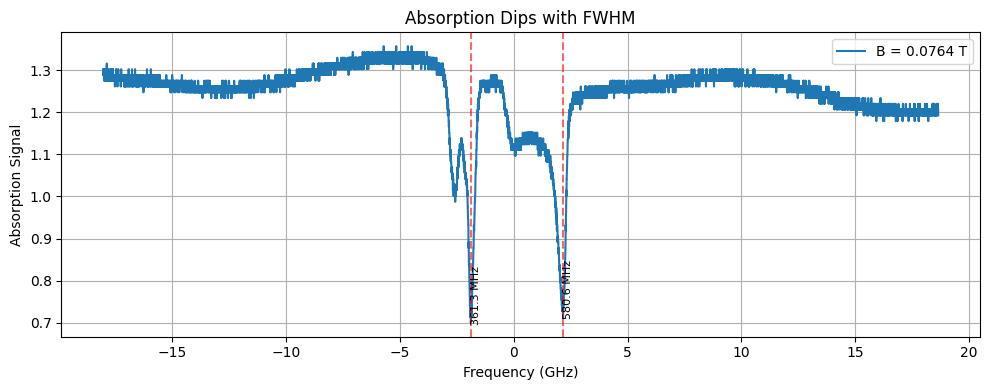


######## Absorption Dip Features ########
Min Frequency (GHz): -1.985845
FWHM (GHz): 0.379686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.971099
FWHM (GHz): 0.379686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.231255
FWHM (GHz): 0.586118
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.253372
FWHM (GHz): 0.586118
Baseline (max signal): 1.357587
Dip Value (min signal): 0.726789
Absorption Depth: 0.630798
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.268118
FWHM (GHz

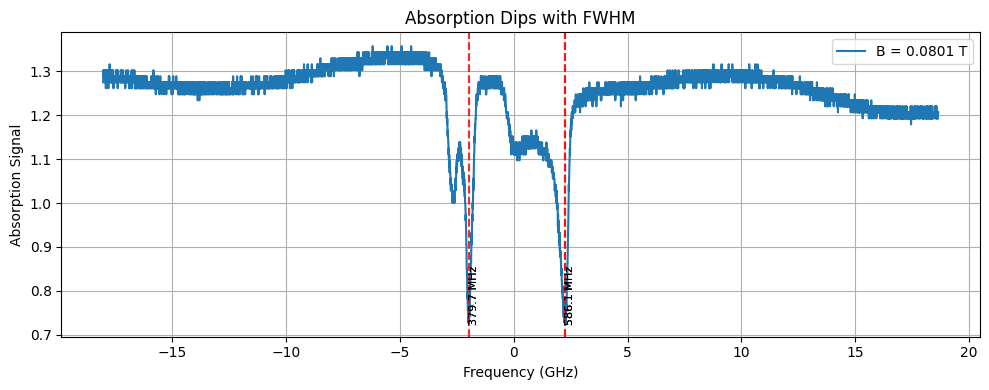


######## Absorption Dip Features ########
Min Frequency (GHz): -2.070629
FWHM (GHz): 0.376000
Baseline (max signal): 1.343874
Dip Value (min signal): 0.740502
Absorption Depth: 0.603372
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.360274
FWHM (GHz): 0.569530
Baseline (max signal): 1.343874
Dip Value (min signal): 0.699363
Absorption Depth: 0.644511
#########################################



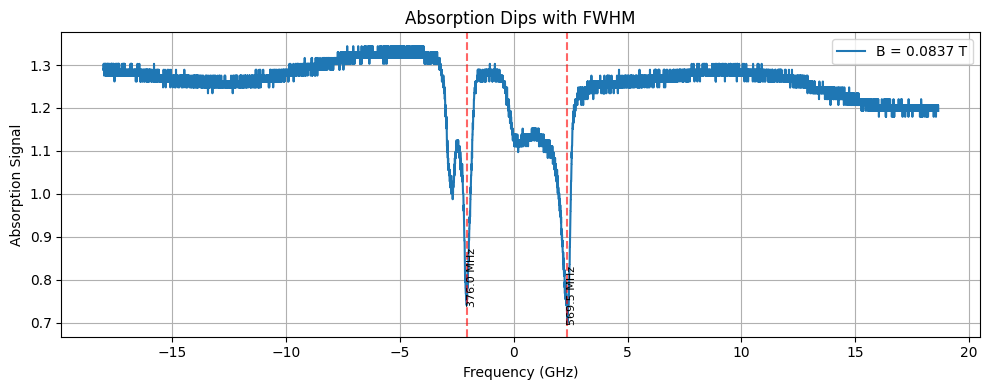


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



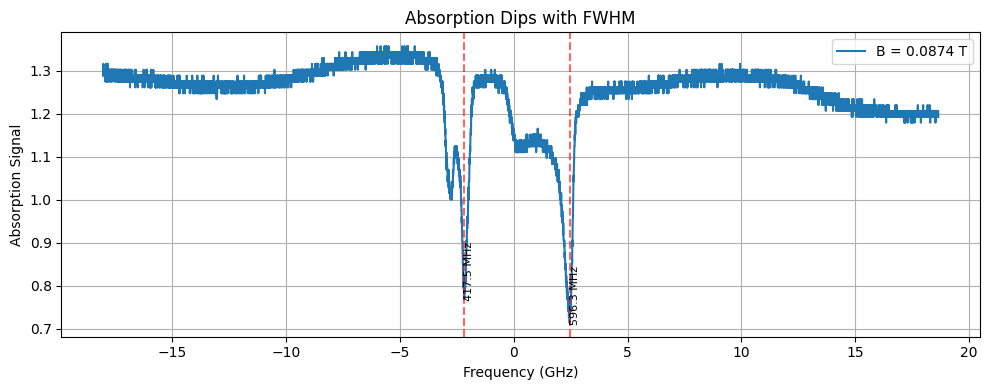

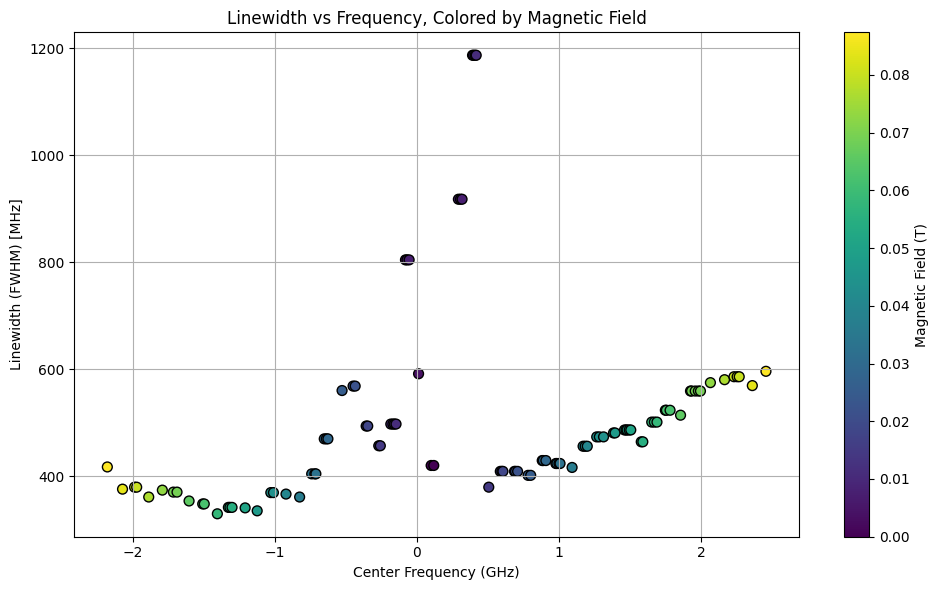

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/"
data_files = sorted(glob.glob(data_path + "*"))

voltages = [] 
fields = []

# Storage for linewidth analysis
all_f_dips = []
all_fwhms = []
all_B_fields = []

for file in data_files: 
    data = pd.read_csv(file, header=None)
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]

# === Extract and store linewidth features === #
for voltage, B in zip(voltages, fields): 
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2)

    # Plot per-spectrum trace (optional)
    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis_GHz, voltage, label=f'B = {B:.4f} T')
    for f in features:
        f_dip = f["f_dip"]
        fwhm = f["FWHM"]
        index = f["index"]

        all_f_dips.append(f_dip)
        all_fwhms.append(fwhm * 1e3)      # Convert FWHM to MHz
        all_B_fields.append(B)

        plt.axvline(f_dip, color='r', linestyle='--', alpha=0.6)
        plt.text(f_dip, voltage[index], f"{fwhm*1e3:.1f} MHz", rotation=90, fontsize=8)

    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Absorption Signal")
    plt.title("Absorption Dips with FWHM")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Final Plot: Linewidth vs Frequency, colored by B-field === #
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_f_dips, all_fwhms, c=all_B_fields, cmap='viridis', s=50, edgecolor='k')
cbar = plt.colorbar(scatter)
cbar.set_label("Magnetic Field (T)")

plt.xlabel("Center Frequency (GHz)")
plt.ylabel("Linewidth (FWHM) [MHz]")
plt.title("Linewidth vs Frequency, Colored by Magnetic Field")
plt.grid(True)
plt.tight_layout()
plt.show()


## LORENTZIAN VERSION ## 


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: 0.065755 GHz
  FWHM:   339.59 MHz
  Depth:  0.8607
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: 0.065755 GHz
  FWHM:   339.59 MHz
  Depth:  0.8607
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 0.064506 GHz
  FWHM:   347.53 MHz
  Depth:  0.8635
#########################################



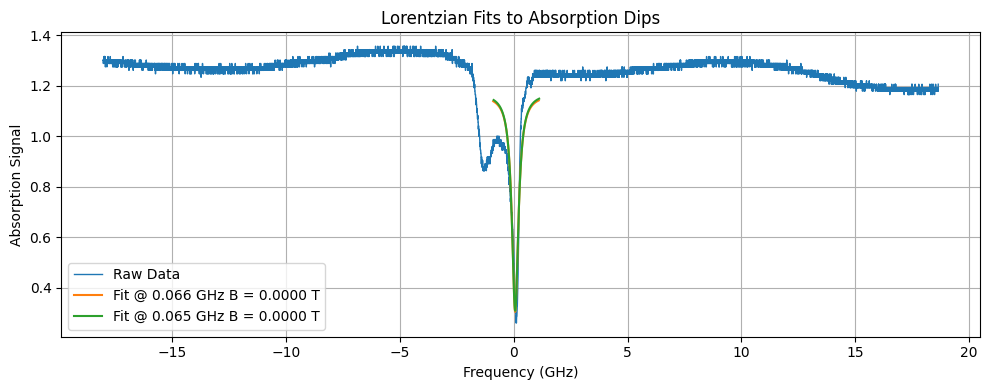


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: 0.035012 GHz
  FWHM:   450.37 MHz
  Depth:  0.7353
#########################################



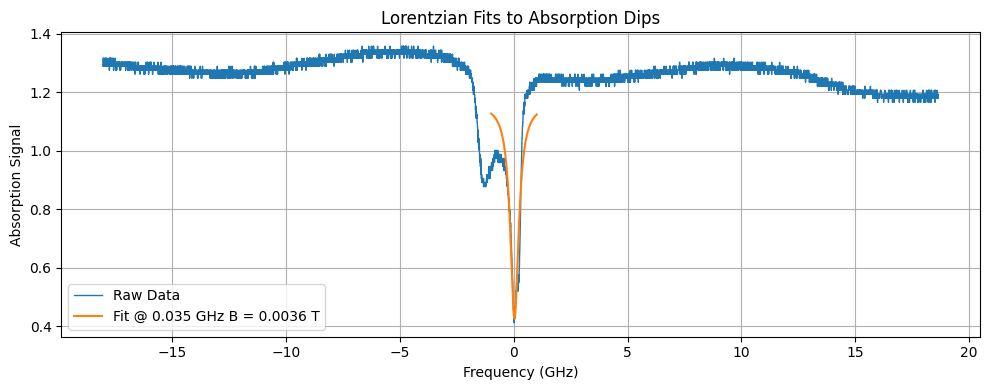


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.041917 GHz
  FWHM:   729.64 MHz
  Depth:  0.5668
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.041917 GHz
  FWHM:   729.64 MHz
  Depth:  0.5668
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.042894 GHz
  FWHM:   755.28 MHz
  Depth:  0.5768
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.041917 GHz
  FWHM:   729.64 MHz
  Depth:  0.5668
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.042894 GHz
  FWHM:   755.28 MHz
  Depth:  0.5768
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -0.044418 GHz
  FWHM:   792.37 MHz
  Depth:  0.5912
#########################################


###

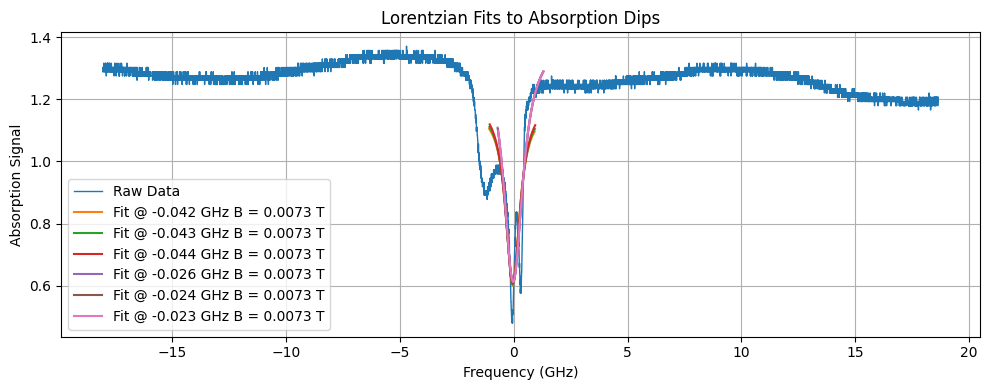


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.175892 GHz
  FWHM:   224.90 MHz
  Depth:  0.4653
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.175892 GHz
  FWHM:   224.90 MHz
  Depth:  0.4653
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.176163 GHz
  FWHM:   231.79 MHz
  Depth:  0.4664
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.175892 GHz
  FWHM:   224.90 MHz
  Depth:  0.4653
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.176163 GHz
  FWHM:   231.79 MHz
  Depth:  0.4664
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -0.176382 GHz
  FWHM:   237.55 MHz
  Depth:  0.4672
#########################################


###

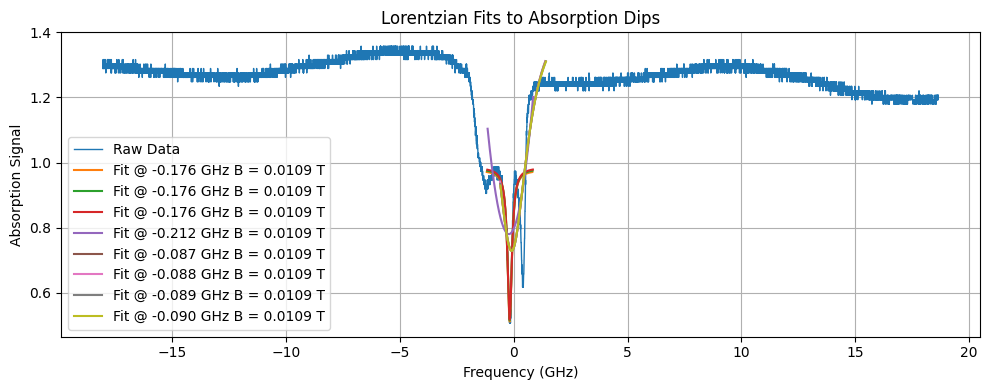


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.268762 GHz
  FWHM:   158.19 MHz
  Depth:  0.4734
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.268762 GHz
  FWHM:   158.19 MHz
  Depth:  0.4734
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.268895 GHz
  FWHM:   -159.60 MHz
  Depth:  0.4745
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.268762 GHz
  FWHM:   158.19 MHz
  Depth:  0.4734
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.268895 GHz
  FWHM:   -159.60 MHz
  Depth:  0.4745
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -0.978512 GHz
  FWHM:   6071.64 MHz
  Depth:  1.5714
#########################################



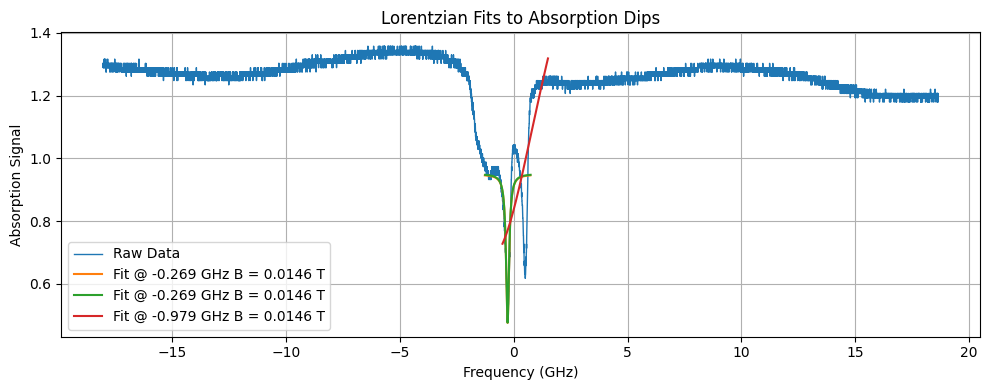


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.368377 GHz
  FWHM:   166.29 MHz
  Depth:  0.4983
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.368377 GHz
  FWHM:   166.29 MHz
  Depth:  0.4983
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.368169 GHz
  FWHM:   164.20 MHz
  Depth:  0.4966
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.368377 GHz
  FWHM:   166.29 MHz
  Depth:  0.4983
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.368169 GHz
  FWHM:   164.20 MHz
  Depth:  0.4966
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -35.548729 GHz
  FWHM:   317917.77 MHz
  Depth:  99.3498
#########################################


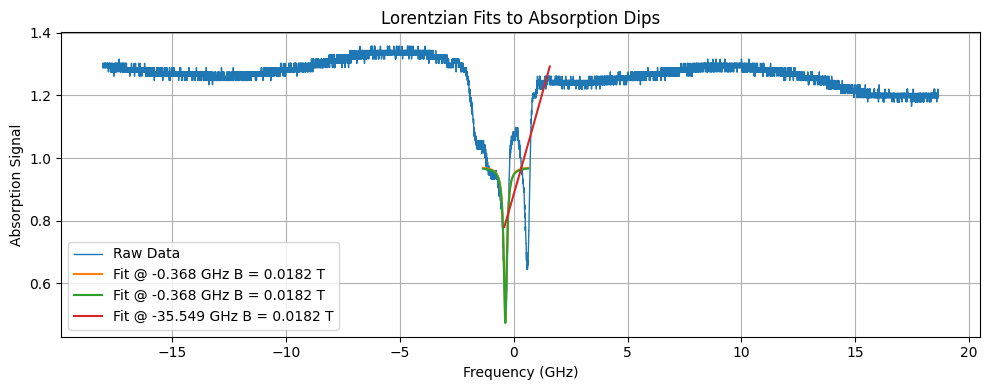


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.472540 GHz
  FWHM:   248.81 MHz
  Depth:  0.5423
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.472540 GHz
  FWHM:   248.81 MHz
  Depth:  0.5423
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.472065 GHz
  FWHM:   245.17 MHz
  Depth:  0.5412
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.472540 GHz
  FWHM:   248.81 MHz
  Depth:  0.5423
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.472065 GHz
  FWHM:   245.17 MHz
  Depth:  0.5412
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 0.660048 GHz
  FWHM:   264.85 MHz
  Depth:  0.5094
#########################################


####

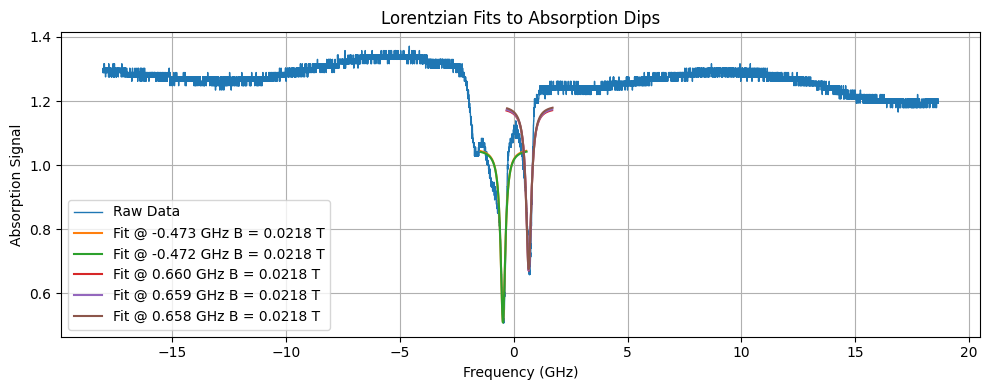


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.568100 GHz
  FWHM:   304.79 MHz
  Depth:  0.5922
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.568100 GHz
  FWHM:   304.79 MHz
  Depth:  0.5922
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 0.759960 GHz
  FWHM:   284.78 MHz
  Depth:  0.5184
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.568100 GHz
  FWHM:   304.79 MHz
  Depth:  0.5922
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 0.759960 GHz
  FWHM:   284.78 MHz
  Depth:  0.5184
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 0.759066 GHz
  FWHM:   290.86 MHz
  Depth:  0.5199
#########################################



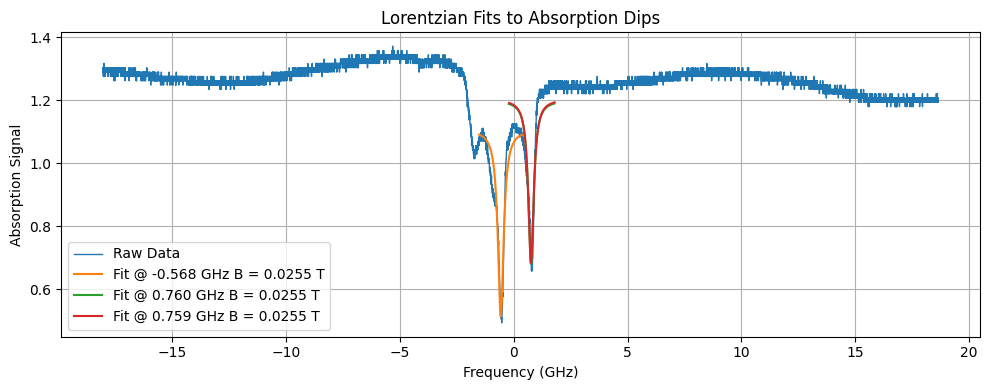


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.657333 GHz
  FWHM:   314.41 MHz
  Depth:  0.6292
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.657333 GHz
  FWHM:   314.41 MHz
  Depth:  0.6292
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.657424 GHz
  FWHM:   315.65 MHz
  Depth:  0.6297
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.657333 GHz
  FWHM:   314.41 MHz
  Depth:  0.6292
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.657424 GHz
  FWHM:   315.65 MHz
  Depth:  0.6297
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -0.657497 GHz
  FWHM:   316.65 MHz
  Depth:  0.6301
#########################################


###

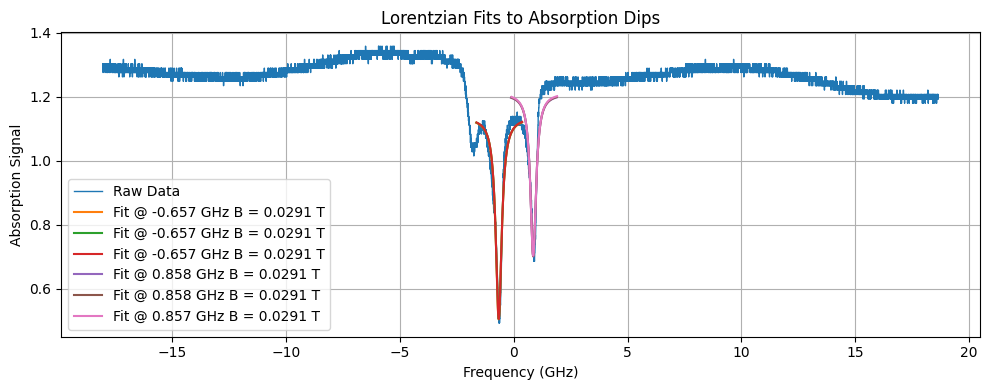


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.743045 GHz
  FWHM:   281.24 MHz
  Depth:  0.6557
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.743045 GHz
  FWHM:   281.24 MHz
  Depth:  0.6557
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.743120 GHz
  FWHM:   283.13 MHz
  Depth:  0.6567
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.743045 GHz
  FWHM:   281.24 MHz
  Depth:  0.6557
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -0.743120 GHz
  FWHM:   283.13 MHz
  Depth:  0.6567
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -0.743141 GHz
  FWHM:   283.70 MHz
  Depth:  0.6570
#########################################


###

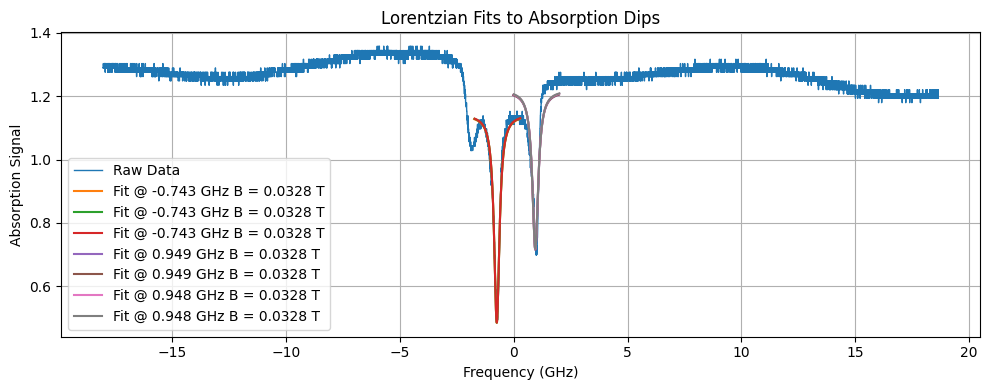


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.825389 GHz
  FWHM:   264.31 MHz
  Depth:  0.6428
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.825389 GHz
  FWHM:   264.31 MHz
  Depth:  0.6428
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.039409 GHz
  FWHM:   332.99 MHz
  Depth:  0.4946
#########################################



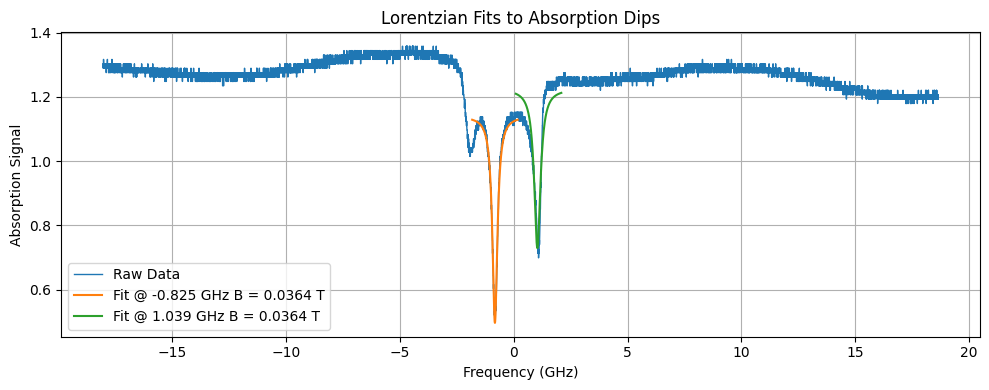


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.914048 GHz
  FWHM:   250.75 MHz
  Depth:  0.5936
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.914048 GHz
  FWHM:   250.75 MHz
  Depth:  0.5936
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.139180 GHz
  FWHM:   335.96 MHz
  Depth:  0.4875
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -0.914048 GHz
  FWHM:   250.75 MHz
  Depth:  0.5936
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.139180 GHz
  FWHM:   335.96 MHz
  Depth:  0.4875
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 1.138690 GHz
  FWHM:   339.46 MHz
  Depth:  0.4884
#########################################


######

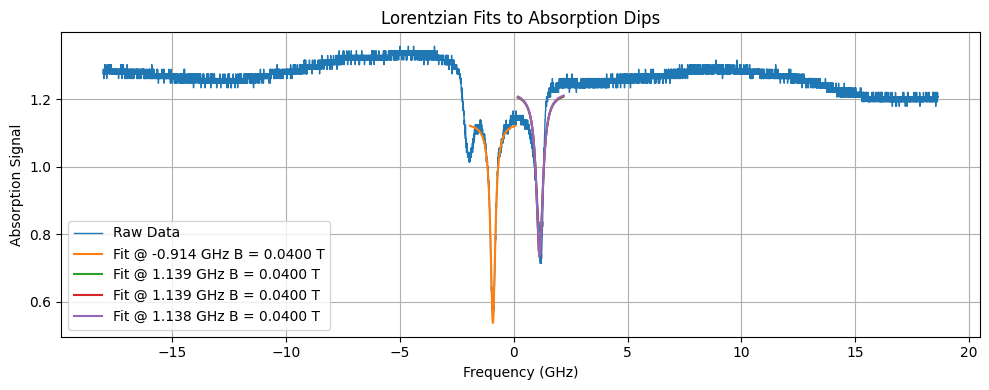


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.014426 GHz
  FWHM:   225.11 MHz
  Depth:  0.5622
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.014426 GHz
  FWHM:   225.11 MHz
  Depth:  0.5622
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.014448 GHz
  FWHM:   227.01 MHz
  Depth:  0.5634
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.014426 GHz
  FWHM:   225.11 MHz
  Depth:  0.5622
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.014448 GHz
  FWHM:   227.01 MHz
  Depth:  0.5634
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 1.232688 GHz
  FWHM:   343.86 MHz
  Depth:  0.4827
#########################################


####

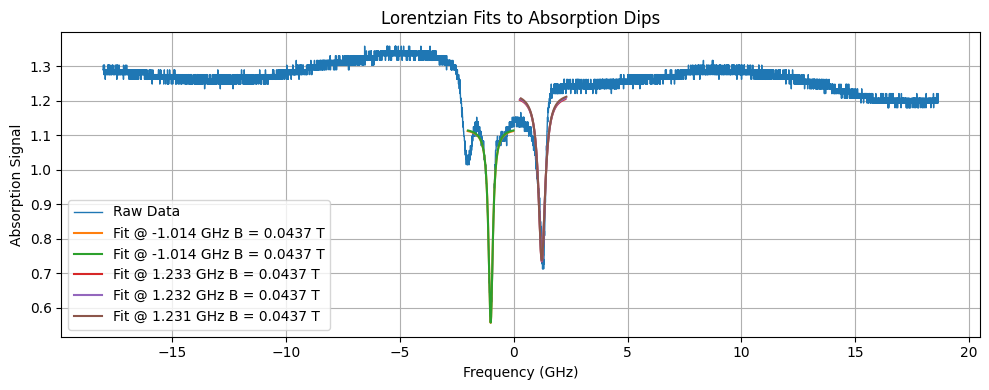


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.117377 GHz
  FWHM:   -203.26 MHz
  Depth:  0.5517
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.117377 GHz
  FWHM:   -203.26 MHz
  Depth:  0.5517
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.323083 GHz
  FWHM:   370.71 MHz
  Depth:  0.4808
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.117377 GHz
  FWHM:   -203.26 MHz
  Depth:  0.5517
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.323083 GHz
  FWHM:   370.71 MHz
  Depth:  0.4808
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 1.322667 GHz
  FWHM:   373.79 MHz
  Depth:  0.4816
#########################################



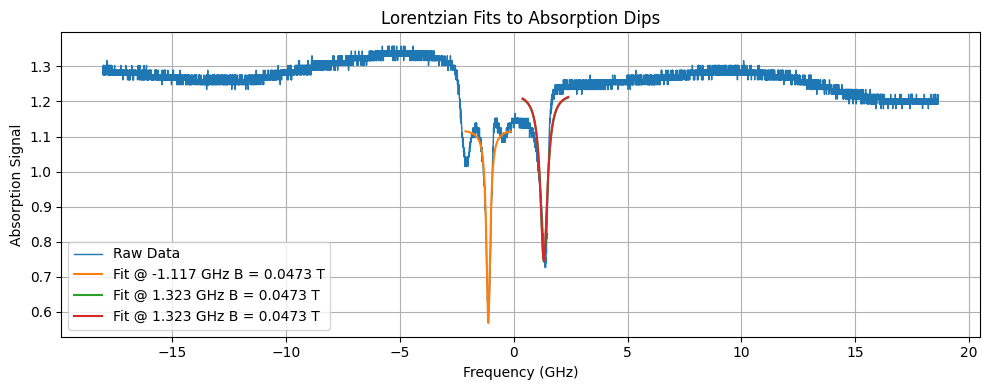


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.213034 GHz
  FWHM:   -201.21 MHz
  Depth:  0.5536
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.213034 GHz
  FWHM:   -201.21 MHz
  Depth:  0.5536
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.420856 GHz
  FWHM:   376.09 MHz
  Depth:  0.4778
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.213034 GHz
  FWHM:   -201.21 MHz
  Depth:  0.5536
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.420856 GHz
  FWHM:   376.09 MHz
  Depth:  0.4778
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 1.420398 GHz
  FWHM:   379.34 MHz
  Depth:  0.4787
#########################################


###

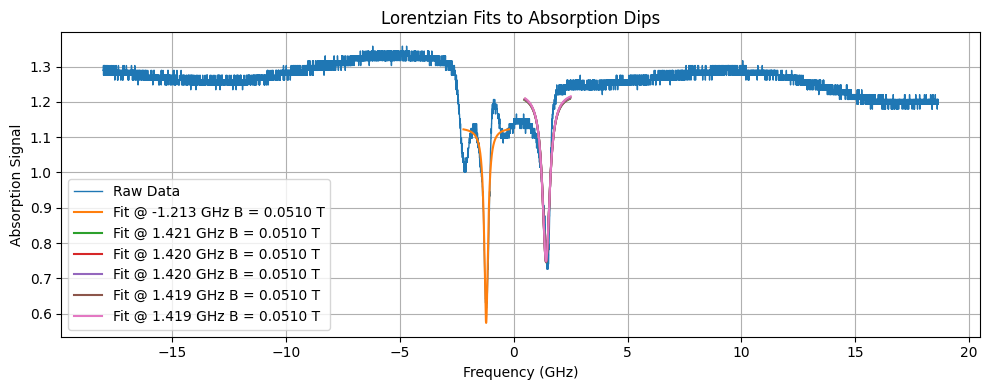


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.312843 GHz
  FWHM:   205.09 MHz
  Depth:  0.5560
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.312843 GHz
  FWHM:   205.09 MHz
  Depth:  0.5560
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.312860 GHz
  FWHM:   205.53 MHz
  Depth:  0.5564
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.312843 GHz
  FWHM:   205.09 MHz
  Depth:  0.5560
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.312860 GHz
  FWHM:   205.53 MHz
  Depth:  0.5564
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -1.312889 GHz
  FWHM:   206.24 MHz
  Depth:  0.5569
#########################################


###

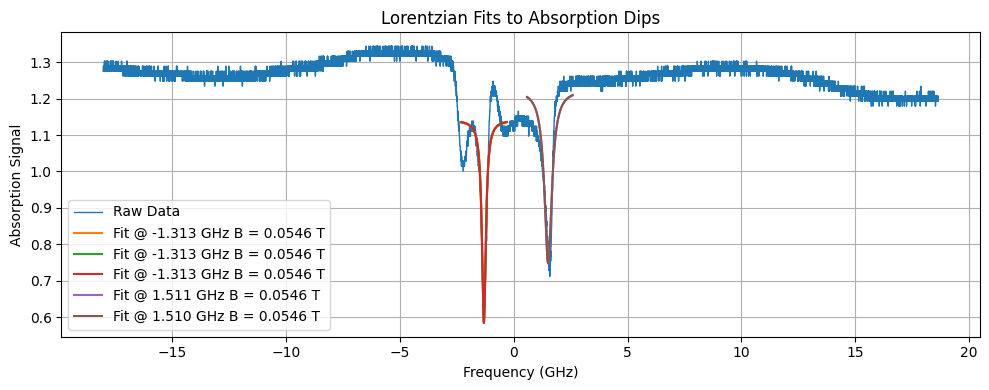


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.405961 GHz
  FWHM:   217.69 MHz
  Depth:  0.5578
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.405961 GHz
  FWHM:   217.69 MHz
  Depth:  0.5578
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.608204 GHz
  FWHM:   395.56 MHz
  Depth:  0.4761
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.405961 GHz
  FWHM:   217.69 MHz
  Depth:  0.5578
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.608204 GHz
  FWHM:   395.56 MHz
  Depth:  0.4761
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 1.607411 GHz
  FWHM:   401.54 MHz
  Depth:  0.4777
#########################################


######

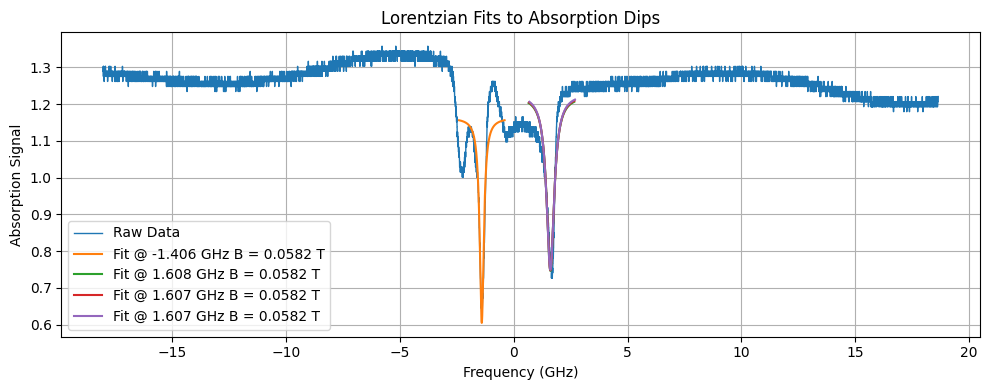


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.504428 GHz
  FWHM:   230.26 MHz
  Depth:  0.5526
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.504428 GHz
  FWHM:   230.26 MHz
  Depth:  0.5526
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.504482 GHz
  FWHM:   231.22 MHz
  Depth:  0.5532
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.504428 GHz
  FWHM:   230.26 MHz
  Depth:  0.5526
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.504482 GHz
  FWHM:   231.22 MHz
  Depth:  0.5532
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 1.698436 GHz
  FWHM:   411.26 MHz
  Depth:  0.4769
#########################################


####

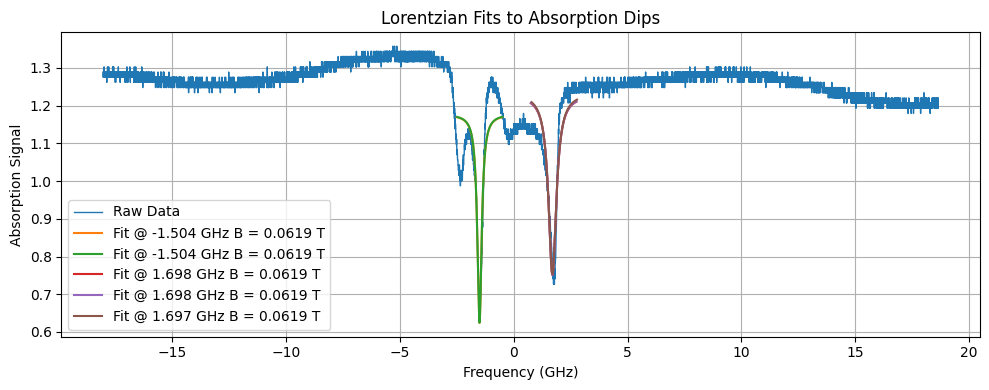


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.598014 GHz
  FWHM:   240.64 MHz
  Depth:  0.5460
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.598014 GHz
  FWHM:   240.64 MHz
  Depth:  0.5460
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.792398 GHz
  FWHM:   427.11 MHz
  Depth:  0.4803
#########################################



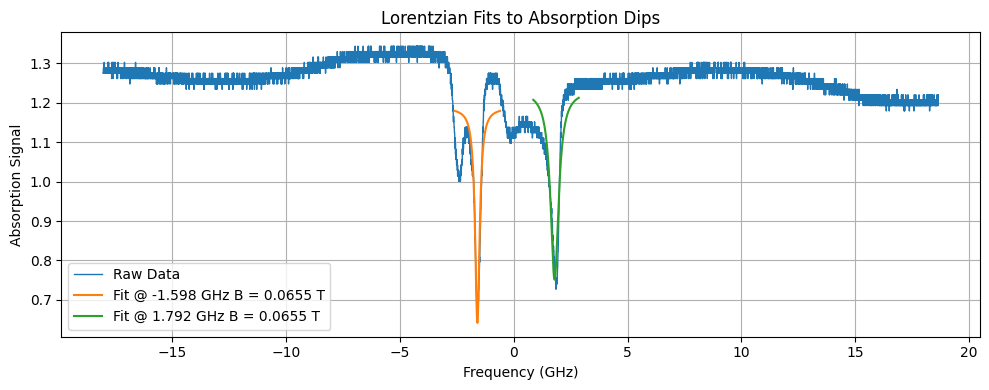


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.696544 GHz
  FWHM:   241.93 MHz
  Depth:  0.5290
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.696544 GHz
  FWHM:   241.93 MHz
  Depth:  0.5290
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.696750 GHz
  FWHM:   245.04 MHz
  Depth:  0.5306
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.696544 GHz
  FWHM:   241.93 MHz
  Depth:  0.5290
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.696750 GHz
  FWHM:   245.04 MHz
  Depth:  0.5306
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 1.887043 GHz
  FWHM:   428.60 MHz
  Depth:  0.4764
#########################################


####

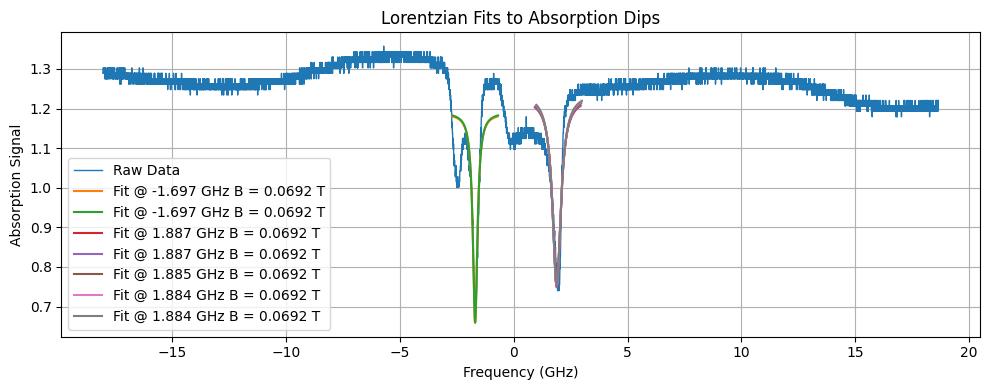


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.793211 GHz
  FWHM:   252.22 MHz
  Depth:  0.5142
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.793211 GHz
  FWHM:   252.22 MHz
  Depth:  0.5142
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 1.972393 GHz
  FWHM:   472.00 MHz
  Depth:  0.4829
#########################################



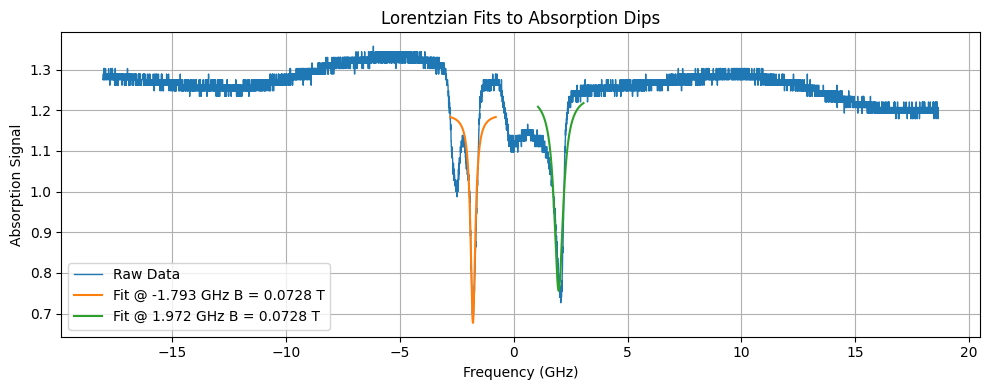


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.886896 GHz
  FWHM:   259.28 MHz
  Depth:  0.4970
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.886896 GHz
  FWHM:   259.28 MHz
  Depth:  0.4970
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 2.068606 GHz
  FWHM:   487.54 MHz
  Depth:  0.4919
#########################################



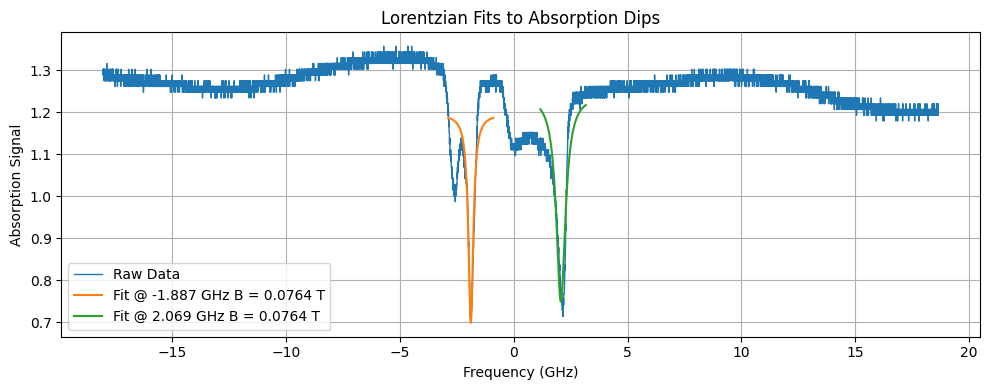


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.984528 GHz
  FWHM:   272.60 MHz
  Depth:  0.4792
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.984528 GHz
  FWHM:   272.60 MHz
  Depth:  0.4792
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.984638 GHz
  FWHM:   273.66 MHz
  Depth:  0.4795
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.984528 GHz
  FWHM:   272.60 MHz
  Depth:  0.4792
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.984638 GHz
  FWHM:   273.66 MHz
  Depth:  0.4795
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: 2.163720 GHz
  FWHM:   488.81 MHz
  Depth:  0.4879
#########################################


####

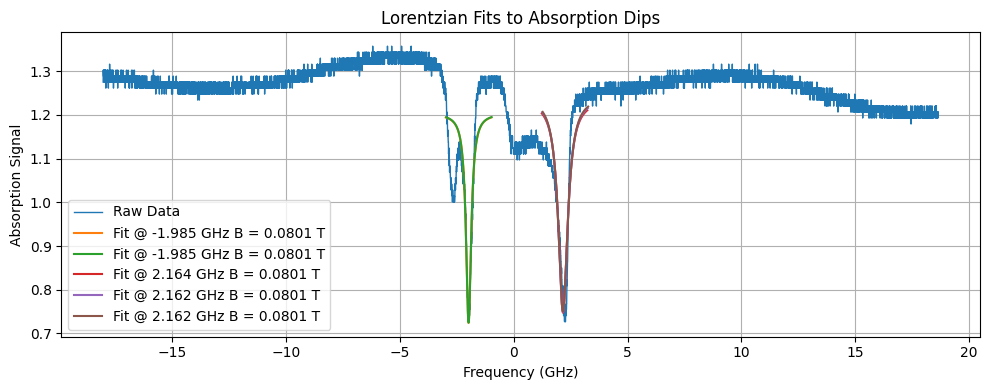


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.081405 GHz
  FWHM:   293.38 MHz
  Depth:  0.4595
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.081405 GHz
  FWHM:   293.38 MHz
  Depth:  0.4595
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 2.254803 GHz
  FWHM:   522.40 MHz
  Depth:  0.4962
#########################################



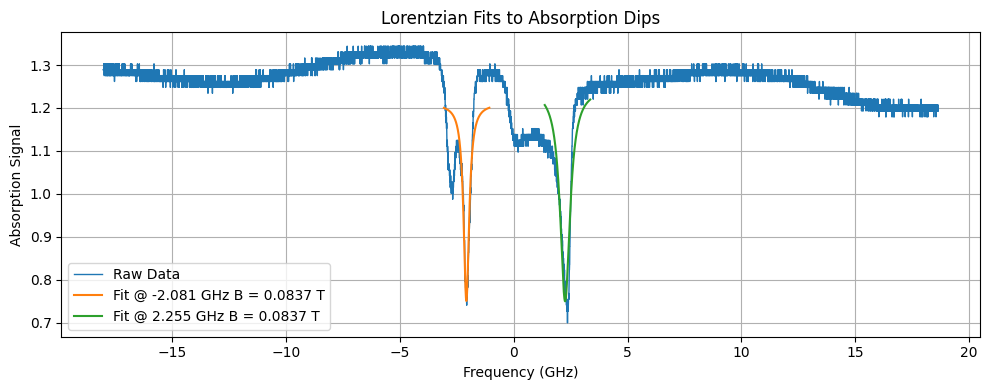


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.180374 GHz
  FWHM:   324.00 MHz
  Depth:  0.4362
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.180374 GHz
  FWHM:   324.00 MHz
  Depth:  0.4362
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: 2.348880 GHz
  FWHM:   541.64 MHz
  Depth:  0.5016
#########################################



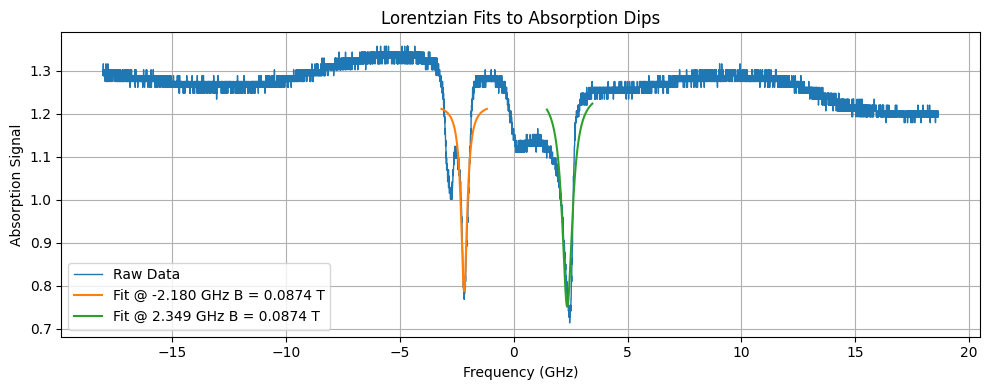

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/"
data_files = sorted(glob.glob(data_path + "*"))

voltages = [] 
fields = []

# Storage for linewidth analysis
all_f_dips = []
all_fwhms = []
all_B_fields = []

for file in data_files: 
    data = pd.read_csv(file, header=None)
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]

# === Extract and store linewidth features === #
for voltage, B in zip(voltages, fields): 
    features = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=2, min_prominence=0.2, to_print=True)
    
    # Plot per-spectrum trace (optional)
    plt.figure(figsize=(10, 4))

    plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

    for f in features:
        if len(features)> 10: 
            raise ValueError("WARNING TOO MANY FITS")
        plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz" + f' B = {B:.4f} T')
        f_dip = f["f_dip"]
        fwhm = f["FWHM"]
        all_f_dips.append(f_dip)
        all_fwhms.append(fwhm * 1e3)      # Convert FWHM to MHz
        all_B_fields.append(B)

    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Absorption Signal")
    #plt.xlim([-5,5])
    plt.title("Lorentzian Fits to Absorption Dips")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



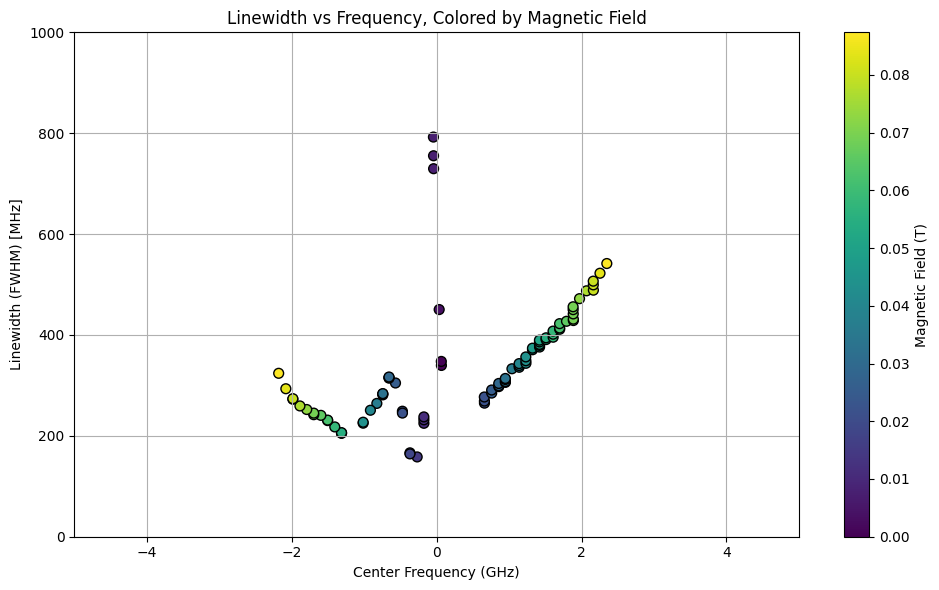

In [58]:
# === Final Plot: Linewidth vs Frequency, colored by B-field === #
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_f_dips, all_fwhms, c=all_B_fields, cmap='viridis', s=50, edgecolor='k')
cbar = plt.colorbar(scatter)
cbar.set_label("Magnetic Field (T)")

plt.xlabel("Center Frequency (GHz)")
plt.ylabel("Linewidth (FWHM) [MHz]")
plt.xlim([-5,5])
plt.ylim([0,1000])
plt.title("Linewidth vs Frequency, Colored by Magnetic Field")
plt.grid(True)
plt.tight_layout()
plt.show()